In [1]:
# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import subprocess
import sys
import tempfile
import time
import typing
import warnings
import zipfile
from functools import partial
from pathlib import Path
from pprint import pprint as ppr

from box import Box

# visualization libraries
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Computation & ML libraries.
import numpy as np
import networkx
import einops
import pandas as pd

import mne

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)

In [2]:
# Data Import
SUBJ_DATA_DIR_ROOT = Path(
    "/data/srv/data/pitn/uva/liu_insula_implant_study/pilot/eeg_scalp_thermal_stim/set_file"
)
assert SUBJ_DATA_DIR_ROOT.exists()

MONTAGE_F = SUBJ_DATA_DIR_ROOT.parent / "eeg_cap_info" / "CACS-64_REF.bvef"
MONTAGE = mne.channels.read_custom_montage(MONTAGE_F)

SUBJ_IDS = ("S001", "S002", "S003")
# SUBJ_IDS = ("S002",)

# Locate files for each subject.
subj_data = Box(default_box=True)
for s in SUBJ_IDS:
    s_f = dict()

    s_dir = SUBJ_DATA_DIR_ROOT / s
    s_f["fdt"] = next(s_dir.glob("Resting_State_Medoc*.fdt"))
    s_f["set"] = next(s_dir.glob("Resting_State_Medoc*.set"))
    subj_data[s].files = s_f

# Based on average adult head sizes according to actiCAP
CAP_CIRCUMFERENCE_CM = 57
head_radius_cm = CAP_CIRCUMFERENCE_CM / (2 * np.pi)
# This is roughly 9 cm, which is "close enough" to 1 decimeter. So, the montage unit
# should just be set to 'dm'.

# Create MNE Raw object readers from files
for s in subj_data.keys():
    # Decimeter montage unit size?
    data = mne.io.read_raw_eeglab(
        subj_data[s].files.set,
        montage_units="dm",
    )
    data.set_montage(
        MONTAGE,
        match_case=False,
        match_alias=True,
        verbose=True,
    )
    subj_data[s].raw = data

Reading /data/srv/data/pitn/uva/liu_insula_implant_study/pilot/eeg_scalp_thermal_stim/set_file/S001/Resting_State_Medoc_S001.fdt
Reading /data/srv/data/pitn/uva/liu_insula_implant_study/pilot/eeg_scalp_thermal_stim/set_file/S002/Resting_State_Medoc_S002.fdt
Reading /data/srv/data/pitn/uva/liu_insula_implant_study/pilot/eeg_scalp_thermal_stim/set_file/S003/Resting_State_Medoc_S003.fdt


/tmp/ipykernel_4054604/1085382006.py:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(
/tmp/ipykernel_4054604/1085382006.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  data.set_montage(
/tmp/ipykernel_4054604/1085382006.py:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(
/tmp/ipykernel_4054604/1085382006.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  data.set_montage(
/tmp/ipykernel_4054604/1085382006.py:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(
/tmp/ipykernel_4054604/10

In [3]:
# Attach additional metadata/cleanup and parse events
THERMAL_RAMPUP_TIME_S = 10.0

for s, data in subj_data.items():
    data.raw.annotations.rename({"R128": "pushbutton"})
    events, _ = mne.events_from_annotations(data.raw, regexp="pushbutton")
    therm_rampup_end_times = data.raw.times[events[:, 0]]
    min_therm_ramp_start_times = therm_rampup_end_times - THERMAL_RAMPUP_TIME_S
    data.raw.annotations.append(
        onset=min_therm_ramp_start_times,
        duration=THERMAL_RAMPUP_TIME_S + 2,
        description=[
            f"possible_therm_ramp" for i in range(len(min_therm_ramp_start_times))
        ],
    )

Used Annotations descriptions: ['pushbutton']
Used Annotations descriptions: ['pushbutton']
Used Annotations descriptions: ['pushbutton']


## Preprocessing

In [4]:
for s in subj_data.keys():
    subj_data[s].preproc = subj_data[s].raw.copy()

In [5]:
# Remove bad channels from the start.
BAD_CHANNELS = {"S002": ("FT10", "AF7", "FT8", "FC2")}

for s in BAD_CHANNELS.keys():
    if s not in subj_data.keys():
        continue
    subj_data[s].preproc.info["bads"] = list(BAD_CHANNELS[s])

BAD_SPANS = {
    "S001": [
        (0.0, 14.877),
        (205.535, 274.775),
        (448.082, 576.625),
    ],
    "S002": [
        (166.914, 188.814),
        (194.137, 197.821),
        (316.695, 318.357),
        (326.071, 327.739),
        (338.782, 342.160),
        (362.216, 365.255),
    ],
    "S003": [(67.062, 94.477), (180.352, 193.434), (395.036, 397.768)],
}


for s in BAD_SPANS.keys():
    if s not in subj_data.keys():
        continue
    onsets = list()
    durs = list()
    for span in BAD_SPANS[s]:
        onsets.append(span[0])
        durs.append(span[1] - span[0])
    subj_data[s].preproc.annotations.append(
        onset=onsets, duration=durs, description="bad_dropout"
    )

In [7]:
# Annotate resting/breaks.
MIN_BREAK_DURATION = 6

for s, data in subj_data.items():
    breaks = mne.preprocessing.annotate_break(
        data.preproc,
        min_break_duration=MIN_BREAK_DURATION,
        t_start_after_previous=5,
        t_stop_before_next=0.5,
        verbose=True,
    )
    breaks.rename({"BAD_break": "break"})
    data.preproc.annotations.append(
        onset=breaks.onset, duration=breaks.duration, description=breaks.description
    )

Ignoring annotations with descriptions starting with: bad, edge

Detected 13 break periods of >= 6 s duration:
    5.0 – 41.5 s [36.5 s]
    59.0 – 72.5 s [13.5 s]
    90.0 – 102.8 s [12.8 s]
    120.3 – 134.3 s [14.0 s]
    151.8 – 164.7 s [12.9 s]
    182.2 – 194.5 s [12.2 s]
    212.0 – 287.2 s [75.2 s]
    304.7 – 317.1 s [12.4 s]
    334.6 – 345.8 s [11.2 s]
    363.3 – 374.2 s [10.9 s]
    391.7 – 403.9 s [12.2 s]
    421.4 – 434.1 s [12.7 s]
    451.6 – 576.8 s [125.2 s]
In total, 62.7% of the data (361.8 s) have been marked as a break.

Ignoring annotations with descriptions starting with: bad, edge

Detected 13 break periods of >= 6 s duration:
    5.0 – 19.4 s [14.4 s]
    36.9 – 49.4 s [12.5 s]
    66.9 – 76.4 s [9.5 s]
    93.9 – 102.8 s [8.9 s]
    120.3 – 127.8 s [7.5 s]
    145.3 – 152.0 s [6.7 s]
    169.5 – 217.3 s [47.8 s]
    234.8 – 243.7 s [8.9 s]
    261.2 – 273.5 s [12.3 s]
    291.0 – 299.7 s [8.7 s]
    317.2 – 324.6 s [7.4 s]
    342.1 – 350.6 s [8.5 s]
    36

In [8]:
# Apply reference channel as the average of all good channels
for s in subj_data.keys():
    subj_data[s].preproc.load_data()
    subj_data[s].preproc.set_eeg_reference("average")

# Filter out power line noise with a notch filter
# Only spikes at 60Hz and 180Hz were visible in these data.
POWER_LINE_FREQS = (60, 180)

for s in subj_data.keys():
    subj_data[s].preproc.load_data()
    subj_data[s].preproc.notch_filter(POWER_LINE_FREQS)

Reading 0 ... 2883899  =      0.000 ...   576.780 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 1860199  =      0.000 ...   372.040 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 1989299  =      0.000 ...   397.860 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 33001 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 33001 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 33001 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


In [ ]:
# r = subj_data.S001.raw.copy()
# r.set_eeg_reference('average')
# r.filter(l_freq=1.0, h_freq=None)
# r.plot(remove_dc=True, butterfly=True);

In [10]:
# Keep track of bridged electrodes for later interpolation.

# Override some bridge indices, as they seem spatially unlikely.
BRIDGE_OVERRIDE = {
    "S002": [(19, 21), (19, 54), (21, 54)],
    "S003": [
        # REMOVE (4, 35) # (FT9, F1)
        # REMOVE (12, 45) # (Pz, PO7))
        (13, 14),  # (P3, P7)
        (13, 47),  # (P3, POz)
        (14, 47),  # (P7, POz)
        (16, 17),  # (Oz, O2)
        (16, 49),  # (Oz, PO8)
        (16, 51),  # (Oz, P2)
        (17, 49),  # (O2, PO8)
        (17, 51),  # (O2, P2)
        (18, 50),  # (P4, P6)
        (19, 21),  # (P8, CP6)
        (19, 54),  # (P8, TP8)
        (21, 54),  # (CP6, TP8)
        # REMOVE (27, 62) # (FC6, F2)
        (49, 51),  # (PO8, P2)
    ],
}

for subj_id in SUBJ_IDS:
    print(subj_id)
    t = subj_data[subj_id].preproc.times
    # Find signal distances on raw data, on a smaller section of the data, ~4 minutes.
    short_span = (
        subj_data[subj_id]
        .preproc.copy()
        .crop(tmin=t.max() - ((4 * 60) + 20), tmax=t.max() - 20)
    )
    short_span.load_data()
    # These parameters are *very* forgiving when it comes to overlooking potential
    # bridges. Otherwise, a ton of the data would be thrown out in at least 2 subjects.
    bridged_idx, ed_matrix = mne.preprocessing.compute_bridged_electrodes(
        short_span, epoch_threshold=0.9, lm_cutoff=5.0, verbose=True
    )

    subj_data[subj_id].bridged_idx = bridged_idx
    subj_data[subj_id].ed_matrix = ed_matrix
    if subj_id in BRIDGE_OVERRIDE.keys():
        print("******* Overriding bridged index for subj", subj_id)
        subj_data[subj_id].bridged_idx = BRIDGE_OVERRIDE[subj_id]

S001
Local minimum 1.5672807272697242 found
Bridge detected between P4 and P8
Bridge detected between P4 and P6
Bridge detected between P8 and P6
S002
Local minimum 1.6776442464406511 found
Bridge detected between O1 and PO4
Bridge detected between P8 and CP6
Bridge detected between P8 and TP8
Bridge detected between P8 and C2
Bridge detected between CP6 and TP8
Bridge detected between CP6 and C2
Bridge detected between TP8 and C2
******* Overriding bridged index for subj S002
S003
Local minimum 1.986380312937491 found
Bridge detected between FT9 and F1
Bridge detected between Pz and PO7
Bridge detected between P3 and P7
Bridge detected between P3 and POz
Bridge detected between P7 and POz
Bridge detected between Oz and O2
Bridge detected between Oz and PO8
Bridge detected between Oz and P2
Bridge detected between O2 and PO8
Bridge detected between O2 and P2
Bridge detected between P4 and P6
Bridge detected between P8 and CP6
Bridge detected between P8 and TP8
Bridge detected between C

In [11]:
# Interpolate virtual channels to fill in the bridged electrodes.
for subj_id in SUBJ_IDS:
    bridge_idx = subj_data[subj_id].bridged_idx
    subj_data[subj_id].preproc = mne.preprocessing.interpolate_bridged_electrodes(
        subj_data[subj_id].preproc, bridge_idx, bad_limit=(len(bridge_idx) * 2)
    )

Creating RawArray with float64 data, n_channels=1, n_times=2883900
    Range : 0 ... 2883899 =      0.000 ...   576.780 secs
Ready.
    Range : 0 ... 2883899 =      0.000 ...   576.780 secs
Ready.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 3 sensors
Creating RawArray with float64 data, n_channels=1, n_times=1860200
    Range : 0 ... 1860199 =      0.000 ...   372.040 secs
Ready.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 3 sensors
Creating RawArray with float64 data, n_channels=1, n_times=1989300
    Range : 0 ... 1989299 =      0.000 ...   397.860 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=1989300
    Range : 0 ... 1989299 =      0.000 ...   397.860 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=1989300
    Range : 0 ... 1989299 = 

In [ ]:
# Visualize bridged connections for a subject.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

s = "S002"
t = subj_data[s].preproc.times
# short_span = (
#     subj_data[s]
#     .preproc.copy()
#     .crop(tmin=t.max() - ((4 * 60) + 20), tmax=t.max() - 20)
# )
short_span = (
    subj_data[s].raw.copy().crop(tmin=t.max() - ((4 * 60) + 20), tmax=t.max() - 20)
)
short_span.load_data()
# These parameters are *very* forgiving when it comes to overlooking potential
# bridges. Otherwise, a ton of the data would be thrown out in at least 2 subjects.
bridged_idx, ed_matrix = mne.preprocessing.compute_bridged_electrodes(
    short_span, epoch_threshold=0.9, lm_cutoff=5.0, verbose=True
)

# med_dist = np.nanquantile(ed_matrix, 0.9, axis=0)
med_dist = np.nanmedian(ed_matrix, axis=0)
im1 = ax1.imshow(med_dist, cmap="magma")
cax1 = fig.colorbar(im1, ax=ax1)
cax1.set_label(r"Electrical Distance ($\mu$$V^2$)")

im2 = ax2.imshow(med_dist, cmap="magma", vmax=5)
cax2 = fig.colorbar(im2, ax=ax2)
cax2.set_label(r"Electrical Distance ($\mu$$V^2$)")
plt.show()

mne.viz.plot_bridged_electrodes(
    # subj_data[s].preproc.info,
    subj_data[s].raw.info,
    bridged_idx,
    ed_matrix,
    topomap_args=dict(vlim=(None, 5)),
)
plt.show()

subset_raws = list()
for pair_i, (br_j, br_k) in enumerate(bridged_idx):
    # ch_j = subj_data[s].preproc.ch_names[br_j]
    # ch_k = subj_data[s].preproc.ch_names[br_k]
    ch_j = subj_data[s].raw.ch_names[br_j]
    ch_k = subj_data[s].raw.ch_names[br_k]

    print(f"({ch_j}, {ch_k}) | ({br_j}, {br_k})")
    subset_raws.append(
        subj_data[s]
        .raw.copy()
        .pick([ch_j, ch_k])
        .rename_channels({ch_j: f"{pair_i}_{ch_j}", ch_k: f"{pair_i}_{ch_k}"})
    )
    # subset_raws.append(
    #     subj_data[s]
    #     .preproc.copy()
    #     .pick([ch_j, ch_k])
    #     .rename_channels({ch_j: f"{pair_i}_{ch_j}", ch_k: f"{pair_i}_{ch_k}"})
    # )
subset_raws[0].add_channels(subset_raws[1:]).plot()

#### EOG Correction

In [12]:
ICA_COMPONENT_VARIANCE_SUM = 0.99
# The number used during reconstruction will be:
# the number of ICA components + (number of PCA components - number of ICA components)
# with the latter term being the "PCA residuals"

### Fit ICA

In [17]:
data.preproc.info

<Info | 10 non-empty values
 bads: 4 items (FT10, AF7, FT8, FC2)
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: True
 dig: 68 items (3 Cardinal, 65 EEG)
 highpass: 0.0 Hz
 lowpass: 2500.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 5000.0 Hz
>

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 16501 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Used Annotations descriptions: ['break']
Not setting metadata
13 matching events found
Setting baseline interval to [-3.0, 3.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 13 events and 30001 original time points ...
0 bad epochs dropped
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 1.4e-11 (2.2e-16 eps * 64 dim * 1e+03  max singular value)
    Estimated rank (eeg): 62
    EEG: rank 62 computed from 64 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 62 (2 small eigenvalues omitted)
Selecting by explained variance: 54 components
Fitting ICA took 258.9s.
Subj S001 ICA | iterations 2883900, components 54
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Used Annotations descriptions: ['break']
Not setting metadata
13 matching events found
Setting baseline interval to [-3.0, 3.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 13 events and 30001 original time points ...
0 bad epochs dropped
Fitting ICA to data using 60 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 4.8e-12 (2.2e-16 eps * 60 dim * 3.6e+02  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 60 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 58 (2 small eigenvalues omitted)
Selecting by explained variance: 52 components
Fitting ICA took 318.1s.
Subj S002 ICA | iterations 1860200, components 52
Reading 0 ... 1989299  =      0.000 ...   397.860 secs...
EEG channel type selected for re-referencing
Applying averag

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Used Annotations descriptions: ['break']
Not setting metadata
12 matching events found
Setting baseline interval to [-3.0, 3.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 30001 original time points ...
0 bad epochs dropped
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.9e-12 (2.2e-16 eps * 64 dim * 2e+02  max singular value)
    Estimated rank (eeg): 55
    EEG: rank 55 computed from 64 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 55 (9 small eigenvalues omitted)
Selecting by explained variance: 16 components
Fitting ICA took 282.5s.
Subj S003 ICA | iterations 1989300, components 16


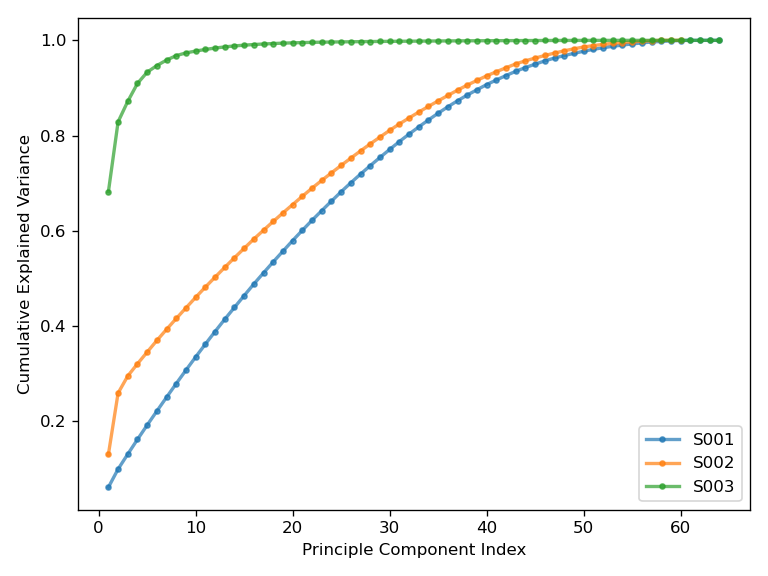

In [18]:
plt.clf()
plt.figure(dpi=120)
for subj_id, data in subj_data.items():
    # Fit ICA to original, raw data
    # High-pass filter to remove potential slow drift.
    raw = data.raw.load_data().copy()
    if len(data.preproc.info["bads"]) > 0:
        raw.info["bads"] = data.preproc.info["bads"]
    raw.set_eeg_reference("average")
    raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=None)

    # Determine the number of PCA components from, roughly, the rank of the output
    # according to the number of "merged" electrodes caused by bridged connections.
    g = networkx.parse_edgelist(
        [f"{i[0]} {i[1]}" for i in list(subj_data[subj_id].bridged_idx)]
    )
    n_cliques = len(list(networkx.find_cliques(g)))
    n_bridges = len(subj_data[subj_id].bridged_idx)
    n_channels = len(set(data.preproc.ch_names) - set(data.preproc.info["bads"]))
    rank = n_channels - n_bridges + n_cliques
    subj_data[subj_id].rank = rank

    # Calculate noise covariance matrix for pre-whitening.
    break_events, break_event_ids = mne.events_from_annotations(
        data.preproc, regexp="break"
    )
    break_epochs = mne.Epochs(
        raw,
        break_events,
        break_event_ids["break"],
        tmin=-MIN_BREAK_DURATION / 2,
        tmax=MIN_BREAK_DURATION / 2,
        baseline=(None, None),
        preload=True,
    )
    noise_cov = mne.compute_covariance(
        break_epochs, rank={"eeg": subj_data[subj_id].rank}, verbose="error"
    )

    ica = mne.preprocessing.ICA(
        n_components=ICA_COMPONENT_VARIANCE_SUM,
        noise_cov=noise_cov,
        method="picard",
        max_iter="auto",
        verbose=True,
    )
    ica = ica.fit(raw_filtered, verbose=True)

    subj_data[subj_id].ica = ica

    print(
        f"Subj {subj_id} ICA | iterations {ica.n_samples_}, components {ica.n_components_}"
    )
    expl_var = ica.pca_explained_variance_ / ica.pca_explained_variance_.sum()
    explained_var_cumsum = np.cumsum(expl_var)
    plt.plot(
        np.arange(explained_var_cumsum.shape[0]) + 1,
        explained_var_cumsum,
        label=subj_id,
        marker=".",
        alpha=0.7,
        lw=2.0,
    )

plt.legend()
plt.xlabel("Principle Component Index")
plt.ylabel("Cumulative Explained Variance")
plt.show()

In [19]:
# Take first N principle components, filter and process.
# subj_preproc_data["S001"]
# subj_preproc_data["S002"]
# subj_preproc_data["S003"]
for subj_id, data in subj_data.items():
    s = subj_data[subj_id].preproc.copy()
    ica = subj_data[subj_id].ica.copy()
    eog_artifact_exclude_idx, eog_artifact_scores = ica.find_bads_eog(
        s, ["Fp1", "Fp2"], start=2.0, measure="zscore", threshold=3.0, verbose=True
    )
    muscle_artifact_exclude_idx, muscle_artifact_scores = ica.find_bads_muscle(
        s, threshold=0.65, l_freq=7, h_freq=45, start=2.0, verbose=True
    )
    print(
        f"EOG components: {eog_artifact_exclude_idx} | Muscle components: {muscle_artifact_exclude_idx}"
    )
    ica.exclude = list(
        set(ica.exclude)
        | set(eog_artifact_exclude_idx)
        | set(muscle_artifact_exclude_idx)
    )

    s = ica.apply(
        s, n_pca_components=subj_data[subj_id].rank, on_baseline="raise", verbose=True
    )

    # Set a reference channel
    s.set_eeg_reference("average")
    # High-pass filter to remove DC offset.
    s.filter(l_freq=1.0, h_freq=None)

    if len(s.info["bads"]) > 0:
        s.interpolate_bads(reset_bads=True, mode="accurate")

    subj_data[subj_id].preproc = s

Using EOG channels: Fp1, Fp2
Omitting 1053300 of 2873900 (36.65%) samples, retaining 1820600 (63.35%) samples.
Omitting 1053300 of 2873900 (36.65%) samples, retaining 1820600 (63.35%) samples.
Omitting 1053300 of 2873900 (36.65%) samples, retaining 1820600 (63.35%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 50000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 50000 samples (10.000 s)

Omitting 1053300 of 2873900 (36.65%) samples, retaining 1820600 (63.35%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transiti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 50000 samples (10.000 s)

Setting 1053300 of 2873900 (36.65%) samples to NaN, retaining 1820600 (63.35%) samples.
Effective window size : 0.410 (s)
EOG components: [45] | Muscle components: [0, 1, 2, 5, 7, 14, 17, 19, 21, 23, 27, 32, 45]
Applying ICA to Raw instance
    Transforming to ICA space (54 components)
    Zeroing out 13 ICA components
    Projecting back using 62 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw dat

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Using EOG channels: Fp1, Fp2
Omitting 176655 of 1850200 (9.55%) samples, retaining 1673545 (90.45%) samples.
Omitting 176655 of 1850200 (9.55%) samples, retaining 1673545 (90.45%) samples.
Omitting 176655 of 1850200 (9.55%) samples, retaining 1673545 (90.45%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 50000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 50000 samples (10.000 s)

Omitting 176655 of 1850200 (9.55%) samples, retaining 1673545 (90.45%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 50000 samples (10.000 s)

Setting 176655 of 1850200 (9.55%) samples to NaN, retaining 1673545 (90.45%) samples.
Effective window size : 0.410 (s)
EOG components: [45] | Muscle components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 24, 28, 30, 32, 35, 36, 38, 40, 44, 45, 46, 47, 49, 50, 51]
Applying ICA to Raw instance
    Transforming to ICA space (52 components)
    Zeroing out 36 ICA components
    Projecting back using 58 PCA components
EEG channel type selected for re-referencin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 4 sensors
Using EOG channels: Fp1, Fp2
Omitting 216145 of 1979300 (10.92%) samples, retaining 1763155 (89.08%) samples.
Omitting 216145 of 1979300 (10.92%) samples, retaining 1763155 (89.08%) samples.
Omitting 216145 of 1979300 (10.92%) samples, retaining 1763155 (89.08%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 50000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


### Resampling & Epoching

In [23]:
for subj_id, data in subj_data.items():
    s = data.preproc.copy()
    pushbutton_events, pushbutton_event_ids = mne.events_from_annotations(
        s, regexp="pushbutton"
    )
    pushb_epochs = mne.Epochs(
        s,
        pushbutton_events,
        pushbutton_event_ids,
        tmin=-10.0,
        tmax=1 / 5000,
        baseline=(None, -4.0),
        preload=True,
    )
    subj_data[subj_id].pushbutton_epochs = pushb_epochs

Used Annotations descriptions: ['pushbutton']
Not setting metadata
12 matching events found
Not setting metadata
12 matching events found
Setting baseline interval to [-10.0, -4.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 50002 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['pushbutton']
Not setting metadata
12 matching events found
Setting baseline interval to [-10.0, -4.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 50002 original time points ...
1 bad epochs dropped
Used Annotations descriptions: ['pushbutton']
Not setting metadata
12 matching events found
Setting baseline interval to [-10.0, -4.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 50002 original time points ...
1 bad epochs dropped


In [24]:
# Resample to a desired frequency.
# current_sample_freq = subj_preproc_data.S001.reduced_eeg.info["sfreq"]
current_sample_freq = 5000
target_sample_freq = 250.0
decim = np.round(current_sample_freq / target_sample_freq).astype(int)
obtained_sample_freq = current_sample_freq / decim
lowpass_freq = obtained_sample_freq / 3.0
print(
    current_sample_freq, target_sample_freq, decim, obtained_sample_freq, lowpass_freq
)

for subj_id, data in subj_data.items():
    s = data.preproc.copy()
    # Low-pass the cleaned data to 1/3 the target frequency. This rule-of-thumb is
    # specifically selected for the default parameters in `Raw.filter()`.
    s = s.filter(l_freq=None, h_freq=lowpass_freq)

    # Re-create the epoching steps above
    pushbutton_events, pushbutton_event_ids = mne.events_from_annotations(
        s, regexp="pushbutton"
    )
    pushb_epochs_decim = mne.Epochs(
        s,
        pushbutton_events,
        pushbutton_event_ids,
        decim=decim,
        tmin=-10.0,
        tmax=0.0,
        baseline=(None, -5.0),
        preload=True,
    )

    subj_data[subj_id].resampled_pushbutton_epochs = pushb_epochs_decim

5000 256.0 20 250.0 83.33333333333333
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 83 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 83.33 Hz
- Upper transition bandwidth: 20.83 Hz (-6 dB cutoff frequency: 93.75 Hz)
- Filter length: 793 samples (0.159 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Used Annotations descriptions: ['pushbutton']
Not setting metadata
12 matching events found
Setting baseline interval to [-10.0, -5.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 83 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 83.33 Hz
- Upper transition bandwidth: 20.83 Hz (-6 dB cutoff frequency: 93.75 Hz)
- Filter length: 793 samples (0.159 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Used Annotations descriptions: ['pushbutton']
Not setting metadata
12 matching events found
Setting baseline interval to [-10.0, -5.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 50001 original time points (prior to decimation) ...
1 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 83 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 83.33 Hz
- Upper transition bandwidth: 20.83 Hz (-6 dB cutoff frequency: 93.75 Hz)
- Filter length: 793 samples (0.159 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Used Annotations descriptions: ['pushbutton']
Not setting metadata
12 matching events found
Not setting metadata
12 matching events found
Setting baseline interval to [-10.0, -5.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 50001 original time points (prior to decimation) ...
1 bad epochs dropped


#### Windowing & Labelling

In [25]:
# fmt: off
CHANNEL_ORDER = (
    'Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3',
    'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1',
    'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz',
    'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2',
    'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1',
    'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz',
    'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6',
    'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'Iz',
)
# fmt: on

In [26]:
# WINDOW_SPAN_TIME = 1.5 #seconds
# window_span_timepoints = math.ceil(WINDOW_SPAN_TIME * target_sample_freq)
# TARGET_BACKOFF_TIMEPOINTS = 1

LOAD_CACHE_DATASET = False
SAVE_CACHE_DATASET = True

input_windows = Box(default_box=True)

In [27]:
if not LOAD_CACHE_DATASET:

    input_windows.times = None

    for subj_id, data in subj_data.items():
        epochs = subj_data[subj_id].resampled_pushbutton_epochs.copy().load_data()
        # Apply baseline correction.
        epochs = epochs.apply_baseline()
        # Channels should be in the correct order, but enforce a standard order just in
        # case.
        epochs = epochs.reorder_channels(list(CHANNEL_ORDER))

        epoch_data = epochs.get_data(picks="eeg", units="uV").copy()

        input_windows[subj_id] = epoch_data

        if input_windows.times is None:
            input_windows.times = epochs.times.copy()

    if SAVE_CACHE_DATASET:
        np.savez_compressed(
            "preproc_eeg_pushbutton_epochs.npz", **input_windows.to_dict()
        )
else:
    input_windows = Box(**np.load("preproc_eeg_pushbutton_epochs.npz"))

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


In [34]:
5000 / 250

20.0

In [ ]:
plt.clf()
plt.plot(input_windows.times, input_windows.S003[0].T, lw=0.3)
plt.show()

---

# Sandbox

In [ ]:
# Testing sandbox
s = subj_data.S002.raw.load_data(verbose=True).copy()

In [ ]:
# EOG artifact correction
s1 = s.copy()

breaks = mne.preprocessing.annotate_break(
    s1, min_break_duration=13, t_start_after_previous=3, t_stop_before_next=3
)
s1.annotations.append(
    onset=breaks.onset, duration=breaks.duration, description=breaks.description
)

eog_epochs = mne.preprocessing.create_eog_epochs(
    s1, ch_name=["Fp1", "Fp2"], l_freq=1, h_freq=40
)
eog_evoked = eog_epochs.average().apply_baseline(baseline=(None, -0.2))

# Visualization of average of eog events
eog_evoked.plot_joint(
    times=[-0.1, -0.01, 0.01, 0.1],
);

In [ ]:
break_events, break_event_ids = mne.events_from_annotations(s1, regexp="BAD_break")
break_epochs = mne.Epochs(
    s1,
    break_events,
    break_event_ids["BAD_break"],
    reject_by_annotation=False,
    preload=True,
)

In [ ]:
breaks.duration

In [ ]:
# Fit ICA to data
# High-pass filter to remove potential slow drift.
s_filter = s.copy().filter(l_freq=1.0, h_freq=None)

ica = mne.preprocessing.ICA(n_components=15, method="picard", max_iter="auto")
ica.fit(s_filter)
ica

In [ ]:
ica.plot_sources(s, show_scrollbars=False)
ica.plot_components();
# ica.plot_overlay(s, exclude=[0, 1], picks='eeg');
# ica.plot_properties(s, picks=[0, 1, 2]);

In [ ]:
# Find components on a second subject.
# Fit ICA to data
# High-pass filter to remove potential slow drift.
s3_filter = subj_data.S003.raw.copy().filter(l_freq=1.0, h_freq=None)

ica_s3 = mne.preprocessing.ICA(n_components=15, method="picard", max_iter="auto")
ica_s3.fit(s3_filter)
ica_s3.plot_components();

In [ ]:
eog_indices, eog_scores = ica.find_bads_eog(
    s, ["Fp1", "Fp2"], threshold=0.7, measure="correlation", l_freq=1.0, h_freq=100
)
print(eog_indices)
print(eog_scores)
# ica.exclude = eog_indices
ica.exclude = [0, 1]

ica.plot_scores(eog_scores)
ica.plot_properties(s, picks=ica.exclude)
ica.plot_sources(eog_evoked);

In [ ]:
ica.find_bads_ecg(s, method="correlation", threshold="auto")

---

**Exploration**

In [ ]:
s = subj_data.S002.raw.copy()
breaks = mne.preprocessing.annotate_break(
    s, min_break_duration=13, t_start_after_previous=3, t_stop_before_next=3
)
s.annotations.append(
    onset=breaks.onset, duration=breaks.duration, description=breaks.description
)

pushbutton_events, pushbutton_event_ids = mne.events_from_annotations(
    s, regexp="pushbutton"
)
pushb_epochs = mne.Epochs(
    s,
    pushbutton_events,
    pushbutton_event_ids,
    tmin=-7.0,
    tmax=0.5,
    baseline=(None, -4.0),
    preload=True,
)
pushb_evoked = pushb_epochs.apply_baseline().average()

# Viz average pushbutton channel amplitudes.
pushb_evoked.plot_joint(
    times=[-6.0, -3.0, -1.0, -0.5, -0.1, -0.05, -0.01, 0.01],
)
pushb_evoked.plot(gfp="only", spatial_colors=True);

In [ ]:
pushb_noise_cov = mne.compute_covariance(
    pushb_epochs, tmax=0, method="shrunk", rank=None, verbose="error"
)
# pushb_epochs.plot(events=True)
# pushb_epochs.plot(noise_cov=pushb_noise_cov, events=True);
pushb_evoked.plot(time_unit="s")
pushb_evoked.plot(noise_cov=pushb_noise_cov, time_unit="s");

In [ ]:
# Plot average intensities per epoch for a second subject

s3 = subj_data.S003.raw.copy()
s3_breaks = mne.preprocessing.annotate_break(
    s3, min_break_duration=13, t_start_after_previous=3, t_stop_before_next=3
)
s3.annotations.append(
    onset=s3_breaks.onset,
    duration=s3_breaks.duration,
    description=s3_breaks.description,
)

s3_pushbutton_events, s3_pushbutton_event_ids = mne.events_from_annotations(
    s3, regexp="pushbutton"
)
s3_pushb_epochs = mne.Epochs(
    s3,
    s3_pushbutton_events,
    s3_pushbutton_event_ids,
    tmin=-7.0,
    tmax=0.5,
    baseline=(None, -4.0),
    preload=True,
)
s3_pushb_evoked = s3_pushb_epochs.apply_baseline().average()

# Viz average pushbutton channel amplitudes.
s3_pushb_evoked.plot_joint(
    times=[-6.0, -3.0, -1.0, -0.5, -0.1, -0.05, -0.01, 0.01],
)
s3_pushb_evoked.plot(gfp="only", spatial_colors=True)

s3_pushb_noise_cov = mne.compute_covariance(
    s3_pushb_epochs, tmax=0, method="shrunk", rank=None, verbose="error"
)
# pushb_epochs.plot(events=True)
# pushb_epochs.plot(noise_cov=pushb_noise_cov, events=True);
s3_pushb_evoked.plot(time_unit="s")
s3_pushb_evoked.plot(noise_cov=s3_pushb_noise_cov, time_unit="s");

In [ ]:
freqs = np.logspace(*np.log10([1, 50]), num=30)
# freqs = np.linspace(1, 10, num=20)
n_cycles = freqs / 2.0  # different number of cycle per frequency
print(f"Temporal windows {n_cycles / freqs} for frequencies {freqs}")
power, itc = mne.time_frequency.tfr_morlet(
    pushb_epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=2,
    n_jobs=None,
)
power.plot_joint(
    mode="mean",
    tmin=-7.0,
    tmax=0.05,
    baseline=(None, -4.0),
    timefreqs=[(-2.99, 10), (-0.1, 9)],
);

In [ ]:
# Time-frequency plot on a second subject
freqs = np.logspace(*np.log10([1, 100]), num=30)
# freqs = np.linspace(1, 10, num=20)
n_cycles = freqs / 10  # different number of cycle per frequency
print(f"Temporal windows {n_cycles / freqs} for frequencies {freqs}")
s3_power, s3_itc = mne.time_frequency.tfr_morlet(
    s3_pushb_epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=2,
    n_jobs=None,
)
s3_power.plot_joint(
    mode="mean",
    tmin=-5.0,
    tmax=0.05,
    baseline=(None, -4.0),
    timefreqs=[(-2.99, 10), (-0.1, 9)],
);

In [ ]:
# Viz of breaks
break_events, break_event_ids = mne.events_from_annotations(s, regexp="BAD_break")
break_epochs = mne.Epochs(
    s,
    break_events,
    break_event_ids["BAD_break"],
    tmin=-3.75,
    tmax=3.75,
    baseline=(None, None),
    reject_by_annotation=False,
    preload=True,
)
break_evoked = break_epochs.apply_baseline().average()
break_evoked.plot_joint(times=[-3, -2, -1, 0, 1, 2, 3]);

#     s,
#     pushbutton_events,
#     pushbutton_event_ids,
#     tmin=-7.0,
#     tmax=0.5,
#     baseline=(None, -4.0),
#     preload=True,
# )
# pushb_evoked = pushb_epochs.apply_baseline().average()

# # Viz average pushbutton channel amplitudes.
# pushb_evoked.plot_joint(
#     times=[-6.0, -3.0, -1.0, -0.5, -0.1, -0.05, -0.01, 0.01],
# );

In [ ]:
pushb_evoked
# break_evoked

---